In [1]:
#-----------------------------------------------------------------------------
# Clears all the variables from the workspace of the spyder application
# might not work unless this cell is explicitly run
# https://stackoverflow.com/questions/45853595/spyder-clear-variable-explorer-along-with-variables-from-memory
def clear_all():   
    gl = globals().copy()
    for var in gl:
        if var[0] == '_': continue
        if 'func' in str(globals()[var]): continue
        if 'module' in str(globals()[var]): continue

        del globals()[var]
if __name__ == "__main__":
    clear_all()

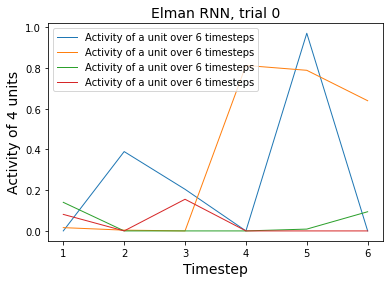

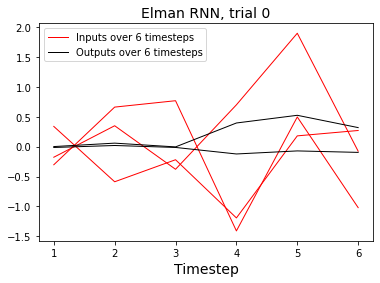

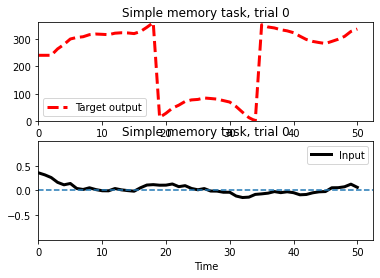

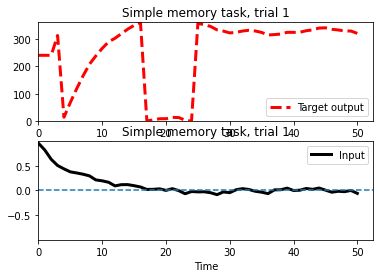

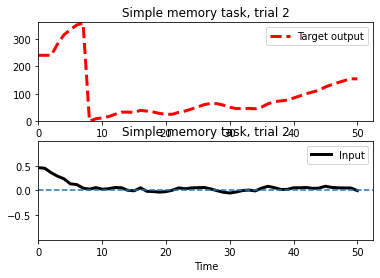

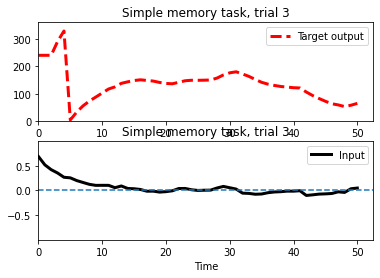

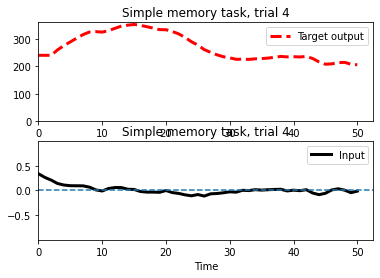

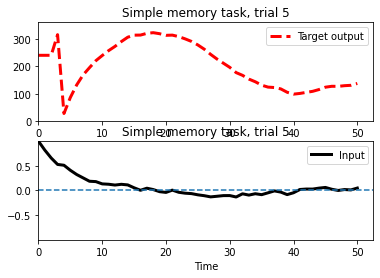

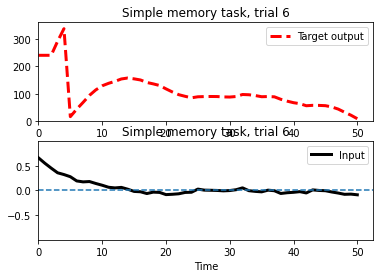

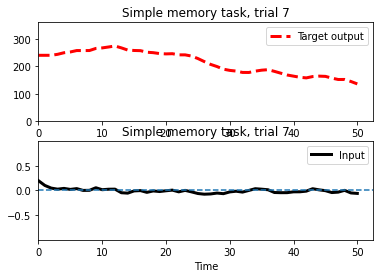

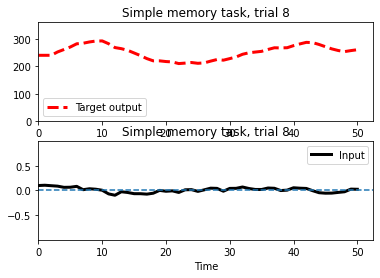

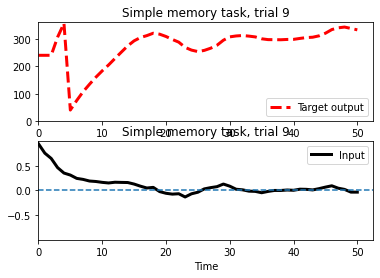

In [2]:
import os
dir = '/Users/user/Documents/University/MIT/Yang_Lab/Chris_RNN_intro/ExampleCode'
os.chdir(dir)# print(f'current working direction is {os.getcwd()}')
import numpy as np# https://stackoverflow.com/questions/11788950/importing-numpy-into-functions
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

%run models.ipynb
%run generateINandTARGETOUT.ipynb

#from models import ElmanRNN# from file import function   
#from generateINandTARGETOUT import generateINandTARGETOUT # from file import function 

randseed = 123
np.random.seed(randseed); torch.manual_seed(randseed)# set random seed for reproducible results 

In [3]:
##############################################################################
#%% initialize network
dim_input = 1# number of inputs
dim_recurrent = 50# number of recurrent units
dim_output = 2# number of outputs
numT = 40# number of timesteps in a trial
numtrials=101# number of trials used for each parameter update, i.e. the number of trials generated by the function generateINandTARGETOUT for each minibatch
numparameterupdates = 1500# number of parameter updates
pset_printerror = np.unique(np.concatenate((np.arange(0,6), np.array([50, 100, 150, 200]), np.round(np.linspace(0,numparameterupdates,num=20,endpoint=True))))).astype(int)# print error when parameter update p is a member of pset_printerror
model = ElmanRNN(dim_input, dim_recurrent, dim_output, LEARN_h0=False); modelname = 'Elman RNN'

#---------------check number of learned parameters---------------
numparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)# model.parameters include those defined in __init__ even if they are not used in forward pass
assert np.allclose(model.numparameters, numparameters), "Number of learned parameters don't match!"

#---------------make folder to store figures---------------
import os
figdir = dir + f'/{modelname.replace(" ", "")}_dimrecurrent{dim_recurrent}_{numparameters}parameters_{numparameterupdates}parameterupdates_rng{randseed}'
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:
##############################################################################
#%% train network
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)# lr = 1e-3 default
error_store = -700*np.ones(numparameterupdates+1)# error_store[0] is the error before any parameter updates have been made, error_store[j] is the error after j parameter updates
figuresuffix = ''
for p in range(numparameterupdates+1):# 0, 1, 2, ... numparameterupdates
    IN, TARGETOUT = generateINandTARGETOUT(dim_input, dim_output, numT, numtrials)
    output, h = model(IN)
    
    #print(IN[1,:,0])
    #print(output[0,0,:], TARGETOUT[0,0,:])
    
    error = torch.sum((output - TARGETOUT)**2) / torch.numel(TARGETOUT)
    error_store[p] = error.item()
    
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights of the model)
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the error with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    error.backward()
     
    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
    if np.isin(p,pset_printerror):
        print(f'{p} parameter updates: error = {error.item():.4g}')

0 parameter updates: error = 0.4954
1 parameter updates: error = 0.4946
2 parameter updates: error = 0.4929
3 parameter updates: error = 0.4921
4 parameter updates: error = 0.4933
5 parameter updates: error = 0.4889
50 parameter updates: error = 0.4456
79 parameter updates: error = 0.4362
100 parameter updates: error = 0.4109
150 parameter updates: error = 0.3429
158 parameter updates: error = 0.2748
200 parameter updates: error = 0.2785
237 parameter updates: error = 0.1597
316 parameter updates: error = 0.1164
395 parameter updates: error = 0.07374
474 parameter updates: error = 0.05218
553 parameter updates: error = 0.0283
632 parameter updates: error = 0.02465
711 parameter updates: error = 0.02166
789 parameter updates: error = 0.01788
868 parameter updates: error = 0.01676
947 parameter updates: error = 0.01035
1026 parameter updates: error = 0.01113
1105 parameter updates: error = 0.009122
1184 parameter updates: error = 0.009013
1263 parameter updates: error = 0.009036
1342 par

In [5]:
#import sys; sys.exit()# stop script at current line    
##############################################################################
#%%
# normalized error, if RNN output is constant for each dim_output (each dim_output can be a different constant) then normalizederror = 100%
# normalizederror = 100*((outputforerror(:) - TARGETOUTforerror(:))' @ (outputforerror(:) - TARGETOUTforerror(:))) / ((mean(TARGETOUTforerror(:)) - TARGETOUTforerror(:))'@(mean(TARGETOUTforerror(:)) - TARGETOUTforerror(:)));
normalizederror = 0;
for i in range(dim_output):
    outputforerror = output[:,:,i]# (numtrials, numT)
    outputforerror = torch.flatten(outputforerror)[:,None]# (numtrials*numT,1)
    TARGETOUTforerror = TARGETOUT[:,:,i]# (numtrial, numT)
    TARGETOUTforerror = torch.flatten(TARGETOUTforerror)[:,None]# (numtrials*numT,1)
    A = outputforerror - TARGETOUTforerror
    B = torch.mean(TARGETOUTforerror) - TARGETOUTforerror
    normalizederror = normalizederror + 100*(A.transpose(0,1) @ A) / (B.transpose(0,1) @ B)
normalizederror = torch.squeeze(normalizederror) / dim_output# use torch.squeeze so normalized error goes from having shape (1,1) to being a number, this makes it easier to plot in figure titles, etc.

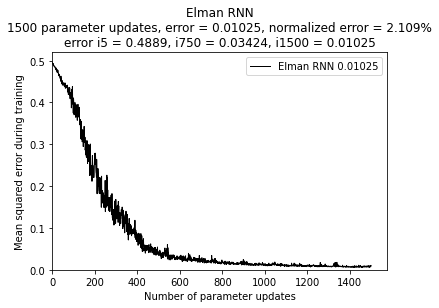

In [6]:
plt.figure()# training error vs number of parameter updates
plt.plot(np.arange(0,numparameterupdates+1), error_store, 'k-', linewidth=1, label=f'{modelname} {error_store[numparameterupdates]:.4g}')
plt.xlabel('Number of parameter updates')
plt.ylabel('Mean squared error during training')
plt.legend()
plt.title('%s\n%.4g parameter updates, error = %.4g, normalized error = %.4g%%\nerror i%g = %.4g, i%g = %.4g, i%g = %.4g'\
          %(modelname,numparameterupdates,error_store[-1],normalizederror,5,error_store[5],round(numparameterupdates/2),error_store[round(numparameterupdates/2)],numparameterupdates,error_store[numparameterupdates]))
plt.xlim(left=0)
plt.ylim(bottom=0)  
plt.savefig('%s/error_trainingerrorVSparameterupdates%s.pdf'%(figdir,figuresuffix), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff

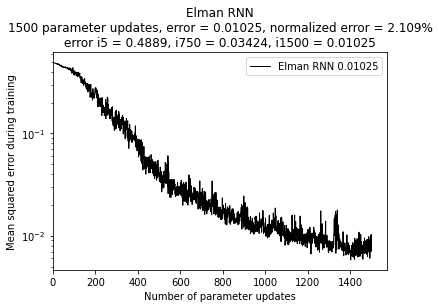

In [7]:
plt.figure()# training error vs number of parameter updates, semilogy
plt.semilogy(np.arange(0,numparameterupdates+1), error_store, 'k-', linewidth=1, label=f'{modelname} {error_store[numparameterupdates]:.4g}')
plt.xlabel('Number of parameter updates')
plt.ylabel('Mean squared error during training')
plt.legend()
plt.title('%s\n%.4g parameter updates, error = %.4g, normalized error = %.4g%%\nerror i%g = %.4g, i%g = %.4g, i%g = %.4g'\
          %(modelname,numparameterupdates,error_store[-1],normalizederror,5,error_store[5],round(numparameterupdates/2),error_store[round(numparameterupdates/2)],numparameterupdates,error_store[numparameterupdates]))
plt.xlim(left=0); 
plt.savefig('%s/error_trainingerrorVSparameterupdates_semilogy%s.pdf'%(figdir,figuresuffix), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff

In [8]:
#%%
##############################################################################
#                            Test data
##############################################################################
np.random.seed(1234); torch.manual_seed(1234)# set random seed for reproducible results
numTtest = 100
numtrialstest = 200
IN, TARGETOUT = generateINandTARGETOUT(dim_input, dim_output, numTtest, numtrialstest)
TARGETOUT = TARGETOUT.numpy()
output, h = model(IN)
output = output.detach().clone().numpy(); h = h.detach().clone().numpy()
# IN:        (numtrialstest, numTtest, dim_input) tensor
# TARGETOUT: (numtrialstest, numTtest, dim_output) tensor
# h:         (numtrialstest, numTtest, dim_recurrent) tensor


# normalized error, if RNN output is constant for each dim_output (each dim_output can be a different constant) then normalizederror = 100%
# normalizederror = 100*((outputforerror(:) - TARGETOUTforerror(:))' @ (outputforerror(:) - TARGETOUTforerror(:))) / ((mean(TARGETOUTforerror(:)) - TARGETOUTforerror(:))'@(mean(TARGETOUTforerror(:)) - TARGETOUTforerror(:)));
normalizederror = 0;
for i in range(dim_output):
    outputforerror = output[:,:,i]# (numtrialstest, numTtest)
    outputforerror = outputforerror.flatten()[:,None]# (something,1)
    TARGETOUTforerror = TARGETOUT[:,:,i]# (numtrialstest, numTtest)
    TARGETOUTforerror = TARGETOUTforerror.flatten()[:,None]# (something,1)
    A = outputforerror - TARGETOUTforerror
    B = np.mean(TARGETOUTforerror) - TARGETOUTforerror
    normalizederror = normalizederror + 100*(A.transpose() @ A) / (B.transpose() @ B)# normalized error when using outputs for which itimeRNN = 1
normalizederror = np.squeeze(normalizederror) / dim_output# use np.squeeze so normalized error goes from having shape (1,1) to being a number, this makes it easier to plot in figure titles, etc.

#import sys; sys.exit()# stop script at current line 

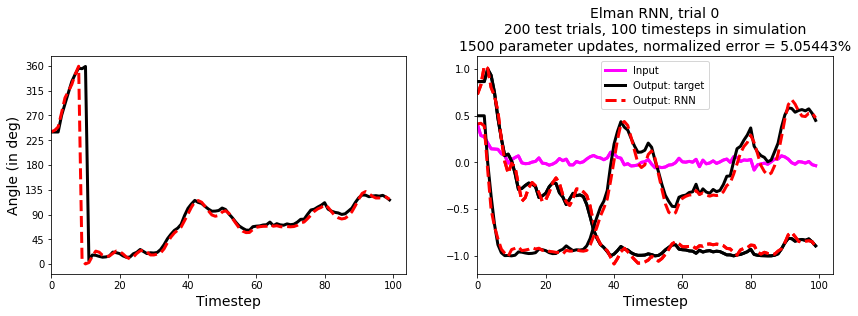

<Figure size 432x288 with 0 Axes>

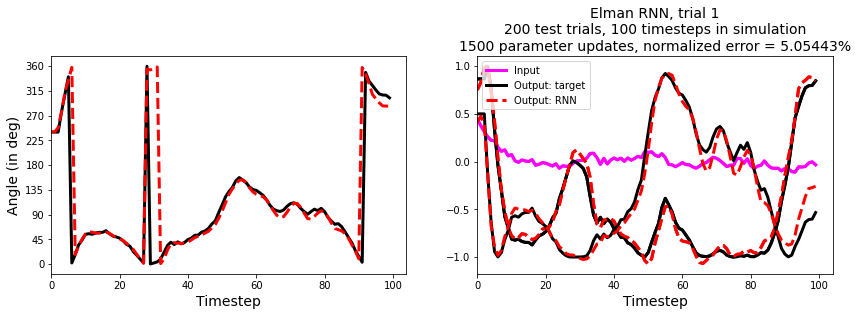

<Figure size 432x288 with 0 Axes>

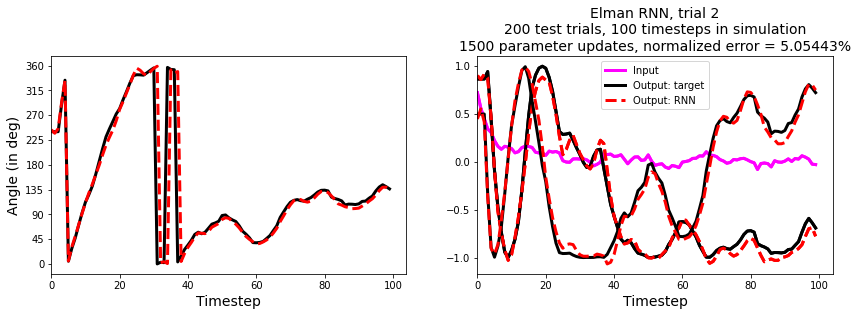

<Figure size 432x288 with 0 Axes>

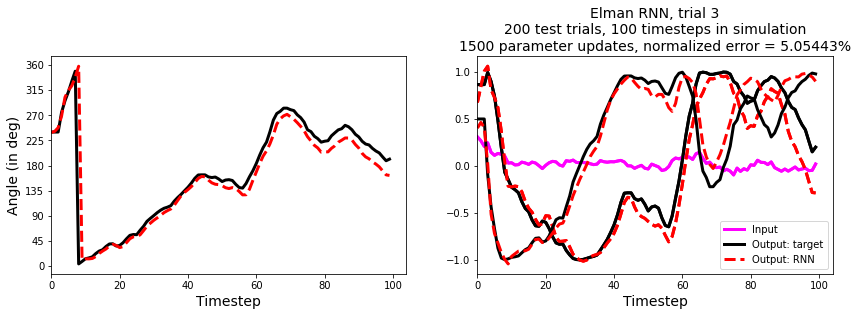

<Figure size 432x288 with 0 Axes>

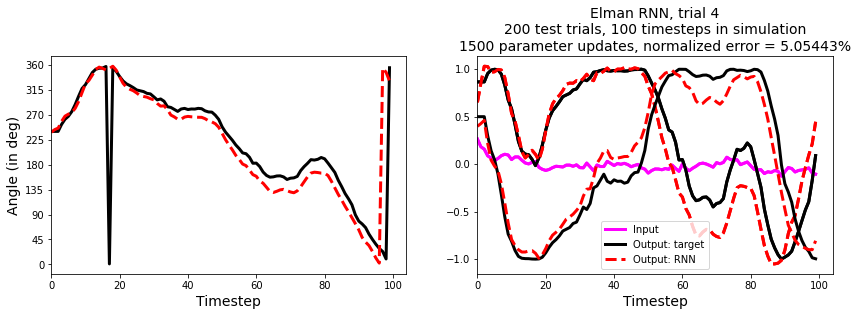

<Figure size 432x288 with 0 Axes>

In [9]:
fontsize = 14
T = np.arange(0,numTtest)# (numTtest,)

#for itrial in range(numtrialstest):
for itrial in range(5):  
    plt.figure(figsize=(14, 4))# RNN inpug and output on test trials
    
    plt.subplot(1, 2, 1)
    TARGETOUT_D = np.degrees(np.arctan2(TARGETOUT[itrial,:,0], TARGETOUT[itrial,:,1]))+180
    plt.plot(T, TARGETOUT_D, c=[0,0,0,1], linewidth=3, label='Output: target')# black
    
    output_d = np.degrees(np.arctan2(output[itrial,:,0], output[itrial,:,1]))+180
    plt.plot(T, output_d, 'r--', linewidth=3, label='Output: RNN')# red
    
    plt.xlabel("Timestep", fontsize=fontsize)
    plt.ylabel("Angle (in deg)", fontsize=fontsize)
    plt.xlim(left=0)
    plt.yticks(np.arange(0,361,45))
    #plt.show()
    
    plt.subplot(1, 2, 2)
    #----colormaps----
    cool = cm.get_cmap('cool', dim_input)
    colormap_input = cool(range(dim_input))# (dim_input, 4) array columns 1,2,3 are the RGB values, column 4 sets the transparency/alpha, datapoint[0] has color colormap[0,:]
    #----plot single input and output for legend----
    plt.plot(T, IN[itrial,:,0], c=colormap_input[0,:], linewidth=3, label='Input'); plt.plot(T, TARGETOUT[itrial,:,0], c=[0,0,0,1], linewidth=3, label='Output: target'); plt.plot(T, output[itrial,:,0], 'r--', linewidth=3, label='Output: RNN')# for legend
    #----plot all inputs and outputs----
    for i in range(dim_input):
        plt.plot(T, IN[itrial,:,i], c=colormap_input[i,:], linewidth=3)
    for i in range(dim_output):
        plt.plot(T, TARGETOUT[itrial,:,i], c=[0,0,0,1], linewidth=3)# black
        plt.plot(T, output[itrial,:,i], 'r--', linewidth=3)# red
    plt.xlabel('Timestep', fontsize=fontsize)
    plt.legend()
    plt.title(f'{modelname}, trial {itrial}\n{numtrialstest} test trials, {numTtest} timesteps in simulation\n{numparameterupdates} parameter updates, normalized error = {normalizederror:.6g}%', fontsize=fontsize)
    plt.xlim(left=0)
    plt.show()
    #plt.show(); input("Press Enter to continue...")# pause the program until the user presses Enter, https://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file
    plt.savefig('%s/testtrial%g_numTtest%g_%gparameterupdates_%s%s.pdf'%(figdir,itrial,numTtest,numparameterupdates,modelname.replace(" ", ""),figuresuffix), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff

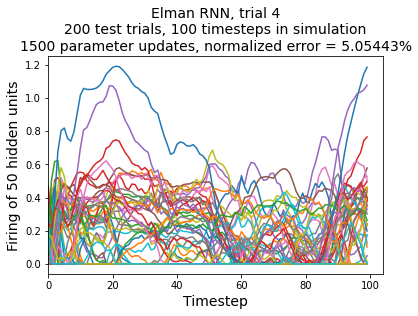

In [10]:
plt.figure()# firing of all hidden units on a single trial
#for itrial in range(numtrialstest):
for itrial in range(5): 
    plt.clf()
    plt.plot(T, h[itrial,:,:])
    plt.xlabel('Timestep', fontsize=fontsize)
    plt.ylabel(f'Firing of {dim_recurrent} hidden units', fontsize=fontsize)
    #plt.legend()
    plt.title(f'{modelname}, trial {itrial}\n{numtrialstest} test trials, {numTtest} timesteps in simulation\n{numparameterupdates} parameter updates, normalized error = {normalizederror:.6g}%', fontsize=fontsize)
    plt.xlim(left=0)
    #plt.show(); input("Press Enter to continue...")# pause the program until the user presses Enter, https://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file
    plt.savefig('%s/testtrial%g_numTtest%g_%gparameterupdates_h_%s%s.pdf'%(figdir,itrial,numTtest,numparameterupdates,modelname.replace(" ", ""),figuresuffix), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff

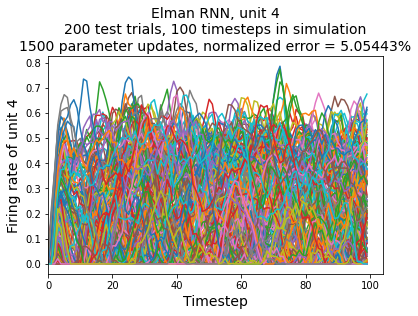

In [11]:
plt.figure()# firing of a single hidden unit across all trials
#for iunit in range(dim_recurrent):
for iunit in range(5): 
    plt.clf()
    plt.plot(T, h[:,:,iunit].transpose())
    plt.xlabel('Timestep', fontsize=fontsize)
    plt.ylabel(f'Firing rate of unit {iunit}', fontsize=fontsize)
    #plt.legend()
    plt.title(f'{modelname}, unit {iunit}\n{numtrialstest} test trials, {numTtest} timesteps in simulation\n{numparameterupdates} parameter updates, normalized error = {normalizederror:.6g}%', fontsize=fontsize)
    plt.xlim(left=0)
    #plt.show(); input("Press Enter to continue...")# pause the program until the user presses Enter, https://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file
    plt.savefig('%s/unit%g_numTtest%g_%gparameterupdates_h_%s%s.pdf'%(figdir,iunit,numTtest,numparameterupdates,modelname.replace(" ", ""),figuresuffix), bbox_inches='tight')# add bbox_inches='tight' to keep title from being cutoff

<ipython-input-12-c95a65787d50>:7: RuntimeWarning: invalid value encountered in true_divide
  return (array-np.min(array))/(np.max(array)-np.min(array))


Neuron #0
Neuron #1
Neuron #2
Neuron #3
Neuron #4
Neuron #5
Neuron #6
Neuron #7
Neuron #8
Neuron #9
Neuron #10
Neuron #11
Neuron #12
Neuron #13
Neuron #14
Neuron #15
Neuron #16
Neuron #17
Neuron #18
Neuron #19
Neuron #20


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


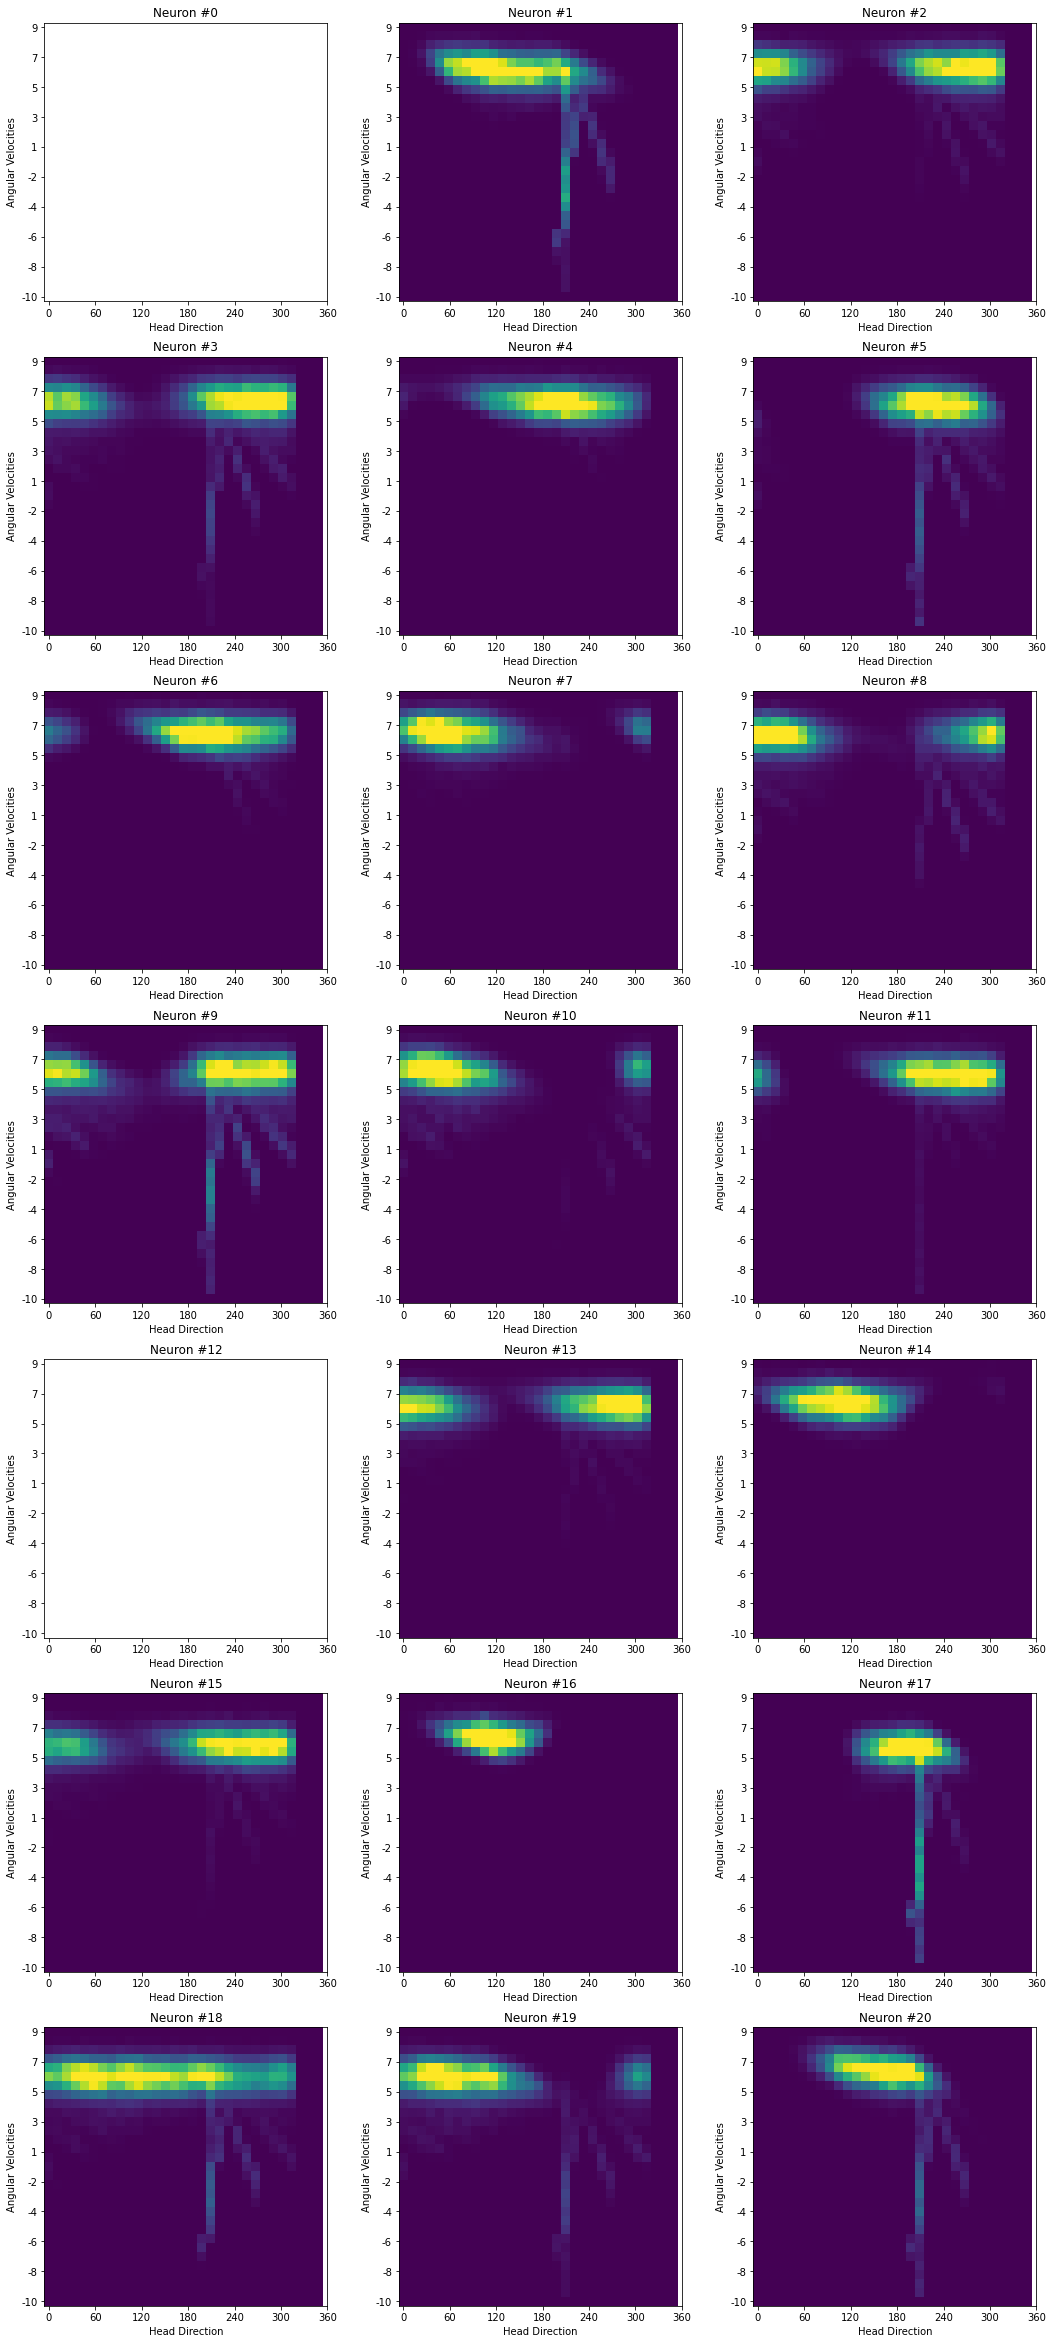

In [12]:
#%run generateINandTARGETOUT.ipynb
# (numtrials, numT, dim_recurrent)

def normalize(array):
    array[array > np.percentile(array,99)] = np.percentile(array,99)
    array[array < np.percentile(array,1)] = np.percentile(array,1)
    return (array-np.min(array))/(np.max(array)-np.min(array))

numtrials = 1000
numT = 100
neuron_count = 21

plt.figure(figsize=(3*6, round(np.ceil(neuron_count/3))*6))

for neuron in range(neuron_count):
    
    plt.subplot(round(np.ceil(neuron_count/3)),3,neuron+1)
    
    IN, TARGETOUT = generateINandTARGETOUT(dim_input, dim_output, numT, numtrials)
    output, h = model(IN)
    output = output.detach().numpy()
    h = h.detach().numpy()
    
    h_vals = np.zeros((numtrials*numT, 31, 31))

    thetas = np.array((np.degrees(np.arctan2(output[:,:,0], output[:,:,1]))+180) / 13, dtype=int)
    AV_category = np.array((IN[:, :, 0]-torch.min(IN))/(torch.max(IN)-torch.min(IN))*30, dtype=int)
    
    for trial in range(numtrials):
        for t in range(numT):
            h_vals[t*numtrials+trial , thetas[trial, t] , AV_category[trial, t]] = h[trial,t,neuron]

    tc = normalize(np.mean(h_vals, axis=0))
    
    print("Neuron #"+str(neuron))
    
    plt.imshow(np.transpose(tc))
    plt.ylabel("Angular Velocities")
    plt.xlabel("Head Direction")
    plt.xticks(np.linspace(0, tc.shape[1], 7), np.linspace(0, 360, 7, dtype=int))
    plt.yticks(np.linspace(0, tc.shape[0]-1, 10), np.linspace(np.deg2rad(550), np.deg2rad(-550), 10, dtype=int))
    plt.title("Neuron #"+str(neuron))